# U-Index Visualizations

Visualizations demonstrating how the U-index differentiates researchers with similar h-indices but different leadership profiles.

This notebook mirrors `u_index_visualizations.py` and uses matplotlib for static figures that render on GitHub.

In [1]:
import random
import matplotlib.pyplot as plt

%matplotlib inline

## Researcher Profiles

Synthetic data representing different researcher archetypes.

In [2]:
RESEARCHERS = [
    {
        "name": "Dr. Early",
        "archetype": "Career Stage",
        "description": "5 years post-PhD, primarily first-author experimental work",
        "h": 12,
        "u": 10,
        "years": 5,
        "h_base_rate": 2.4,
        "collab_bonus": 0.4,
    },
    {
        "name": "Dr. Midcareer",
        "archetype": "Career Stage",
        "description": "12 years in, mix of independent and supervised research",
        "h": 25,
        "u": 18,
        "years": 12,
        "h_base_rate": 1.5,
        "collab_bonus": 0.58,
    },
    {
        "name": "Dr. Senior",
        "archetype": "Career Stage",
        "description": "25 years experience, leads large lab with heavy supervision",
        "h": 45,
        "u": 22,
        "years": 25,
        "h_base_rate": 0.88,
        "collab_bonus": 0.92,
    },
    {
        "name": "Dr. Independent",
        "archetype": "Leadership Style",
        "description": "Runs small lab, still does own experiments",
        "h": 20,
        "u": 18,
        "years": 15,
        "h_base_rate": 1.2,
        "collab_bonus": 0.13,
    },
    {
        "name": "Dr. Collaborative",
        "archetype": "Leadership Style",
        "description": "Hub in large consortiums, many middle-author papers",
        "h": 35,
        "u": 8,
        "years": 15,
        "h_base_rate": 0.53,
        "collab_bonus": 1.8,
    },
    {
        "name": "Dr. Balanced",
        "archetype": "Leadership Style",
        "description": "Equal leadership and collaboration contributions",
        "h": 28,
        "u": 14,
        "years": 15,
        "h_base_rate": 0.93,
        "collab_bonus": 0.93,
    },
    {
        "name": "Dr. Consortium",
        "archetype": "Edge Case",
        "description": "Almost entirely middle-author consortium positions",
        "h": 40,
        "u": 3,
        "years": 20,
        "h_base_rate": 0.15,
        "collab_bonus": 1.85,
    },
    {
        "name": "Dr. Solo",
        "archetype": "Edge Case",
        "description": "Single-author theoretician, all papers are first/last",
        "h": 15,
        "u": 15,
        "years": 20,
        "h_base_rate": 0.75,
        "collab_bonus": 0.0,
    },
]

## Helper Function: Generate Career Trajectory

In [3]:
def generate_trajectory(researcher: dict, seed: int = 42) -> list[tuple[int, int, int]]:
    """
    Generate a career trajectory showing h and U values over time.

    Returns list of (year, h, u) tuples.
    """
    random.seed(seed + hash(researcher["name"]))

    trajectory = [(0, 0, 0)]
    h_cumulative = 0.0
    u_cumulative = 0.0

    h_base = researcher["h_base_rate"]
    collab = researcher["collab_bonus"]

    for year in range(1, researcher["years"] + 1):
        noise_h = random.uniform(-0.2, 0.3)
        noise_u = random.uniform(-0.15, 0.25)

        h_cumulative += h_base + collab + noise_h
        u_cumulative += h_base + noise_u

        # Ensure monotonic growth
        h_cumulative = max(h_cumulative, trajectory[-1][1])
        u_cumulative = max(u_cumulative, trajectory[-1][2])

        # U can never exceed h (mathematical property)
        u_cumulative = min(u_cumulative, h_cumulative)

        trajectory.append((year, int(h_cumulative), int(u_cumulative)))

    final_h = researcher["h"]
    final_u = researcher["u"]
    scale_h = final_h / max(trajectory[-1][1], 1)
    scale_u = final_u / max(trajectory[-1][2], 1)

    scaled = [(0, 0, 0)]
    for year, h, u in trajectory[1:]:
        scaled_h = int(h * scale_h)
        scaled_u = int(u * scale_u)
        # Ensure U <= h after scaling
        scaled_u = min(scaled_u, scaled_h)
        scaled.append((year, scaled_h, scaled_u))

    scaled[-1] = (researcher["years"], final_h, final_u)

    return scaled

## H-index vs U-index Scatter Plot

This plot shows the relationship between h-index (total impact) and U-index (leadership impact) for eight simulated researcher profiles.

- **Diagonal line**: Represents U = h (all papers are first/last authored)
- **Gray shaded area**: Impossible zone (U cannot exceed h)
- **Points colored by category**: Career Stage, Leadership Style, Edge Cases

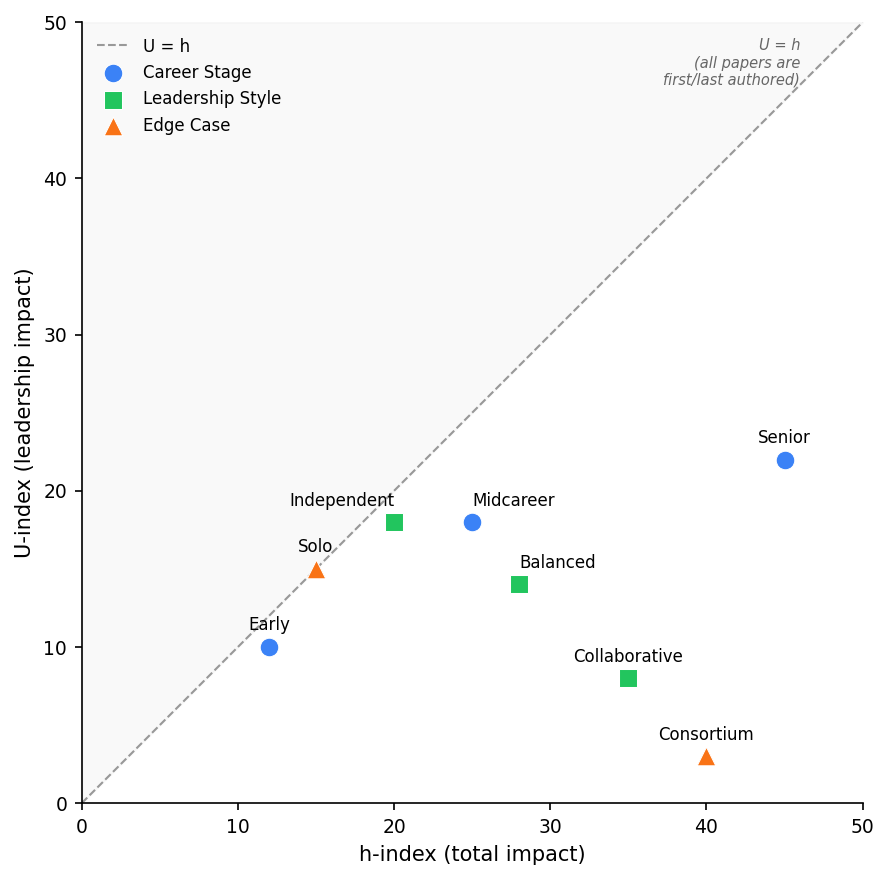

In [4]:
def create_scatter_plot():
    """Create scatter plot showing h vs U for all researchers."""

    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

    # Add diagonal line (U = h)
    max_val = max(r["h"] for r in RESEARCHERS) + 5
    ax.plot([0, max_val], [0, max_val], color="#999", linewidth=1, linestyle="--",
            label="U = h", zorder=1)

    # Fill above diagonal to show "impossible zone" (U cannot exceed h)
    ax.fill_between([0, max_val], [0, max_val], [max_val, max_val], alpha=0.05, color="#999")

    # Color and marker by archetype
    archetype_styles = {
        "Career Stage": {"color": "#3b82f6", "marker": "o"},
        "Leadership Style": {"color": "#22c55e", "marker": "s"},
        "Edge Case": {"color": "#f97316", "marker": "^"},
    }

    # Plot researchers
    for archetype, style in archetype_styles.items():
        researchers = [r for r in RESEARCHERS if r["archetype"] == archetype]
        h_vals = [r["h"] for r in researchers]
        u_vals = [r["u"] for r in researchers]
        ax.scatter(h_vals, u_vals, c=style["color"], marker=style["marker"],
                   s=80, label=archetype, zorder=3, edgecolors="white", linewidths=0.5)

        # Add labels
        for r in researchers:
            label = r["name"].replace("Dr. ", "")
            ha = "center"
            if label == "Independent":
                ha = "right"
            elif label in ("Midcareer", "Balanced"):
                ha = "left"
            ax.annotate(label, (r["h"], r["u"]), textcoords="offset points",
                        xytext=(0, 8), ha=ha, fontsize=8)

    ax.set_xlabel("h-index (total impact)", fontsize=10)
    ax.set_ylabel("U-index (leadership impact)", fontsize=10)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect("equal")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=8, loc="upper left", frameon=False)
    ax.tick_params(labelsize=9)

    # Add annotation explaining the diagonal
    ax.annotate("U = h\n(all papers are\nfirst/last authored)",
                xy=(max_val - 4, max_val - 4), fontsize=7, color="#666", ha="right",
                style="italic")

    plt.tight_layout()
    return fig

create_scatter_plot()
plt.show()

## Stacked Bar Chart: Leadership vs Collaboration

This chart decomposes each researcher's h-index into:
- **Blue (bottom)**: U-index (leadership impact from first/last author papers)
- **Gray (top)**: Collaboration contribution (h - U, from middle-author positions)

The total bar height equals the h-index.

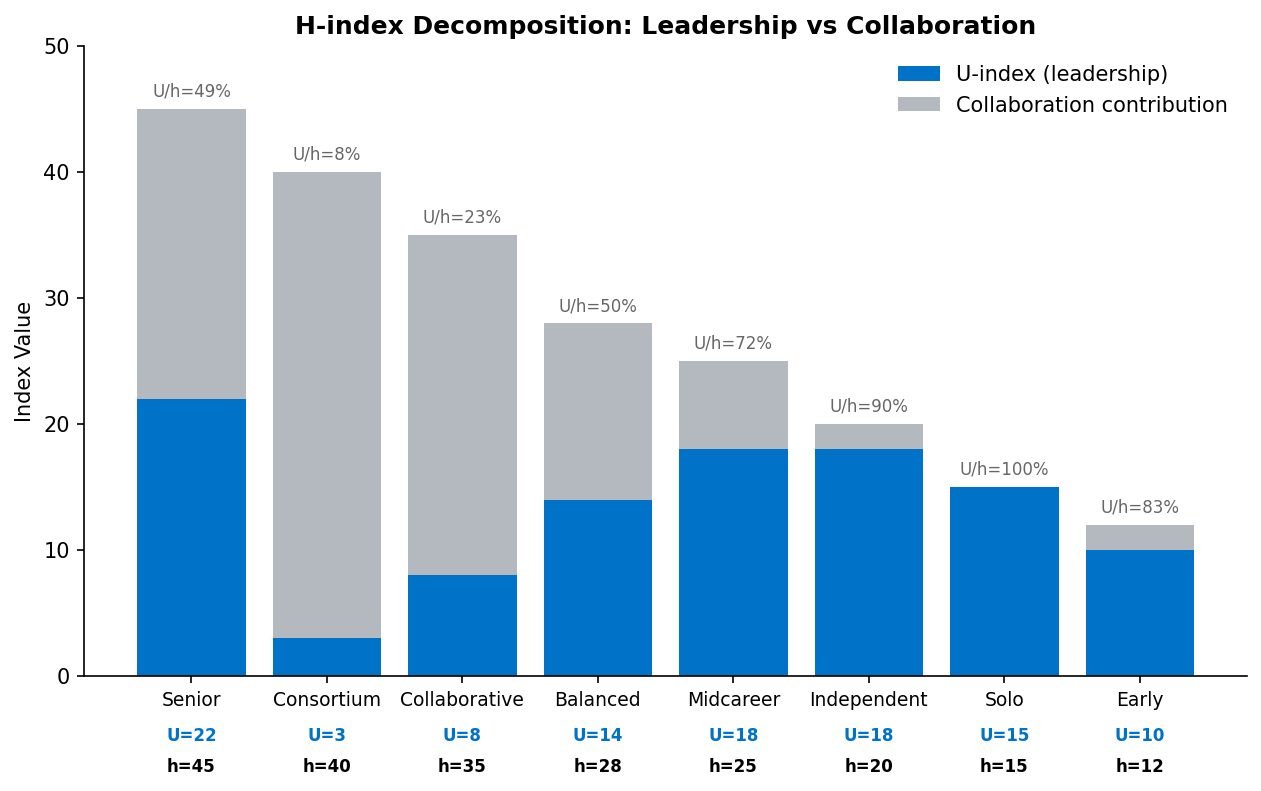

In [5]:
def create_bar_chart():
    """Create stacked bar chart comparing h and U across all researchers."""

    sorted_researchers = sorted(RESEARCHERS, key=lambda r: r["h"], reverse=True)

    names = [r["name"].replace("Dr. ", "") for r in sorted_researchers]
    h_values = [r["h"] for r in sorted_researchers]
    u_values = [r["u"] for r in sorted_researchers]
    collab_values = [h - u for h, u in zip(h_values, u_values)]
    ratios = [f"{u/h:.0%}" for h, u in zip(h_values, u_values)]

    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    x = range(len(names))

    # U-index bars (bottom)
    ax.bar(x, u_values, color="#0073c8", label="U-index (leadership)")

    # Collaboration bars (top)
    ax.bar(x, collab_values, bottom=u_values, color="#6b7280", alpha=0.5,
           label="Collaboration contribution")

    # Add ratio labels
    for i, (h, ratio) in enumerate(zip(h_values, ratios)):
        ax.annotate(f"U/h={ratio}", (i, h + 1), ha="center", fontsize=8, color="#666")

    ax.set_xticks(x)
    ax.set_xticklabels(names, fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("Index Value", fontsize=10)
    ax.set_title("H-index Decomposition: Leadership vs Collaboration", fontsize=12, fontweight="bold")
    ax.legend(loc="upper right", frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(0, max(h_values) + 5)

    # Add U and h values as text below each bar using axis transform
    trans = ax.get_xaxis_transform()
    for i, (u, h) in enumerate(zip(u_values, h_values)):
        ax.text(i, -0.08, f"U={u}", ha="center", va="top", fontsize=8,
                color="#0073c8", fontweight="bold", transform=trans)
        ax.text(i, -0.13, f"h={h}", ha="center", va="top", fontsize=8,
                color="black", fontweight="bold", transform=trans)

    plt.subplots_adjust(bottom=0.18)
    return fig

create_bar_chart()
plt.show()

## Career Trajectories

Shows how h-index and U-index diverge over time for different researcher profiles.

- **Solid line**: U-index (leadership impact)
- **Dashed line**: h-index (total impact)
- **Dark shaded area**: Leadership contribution
- **Light shaded area**: Collaboration gap

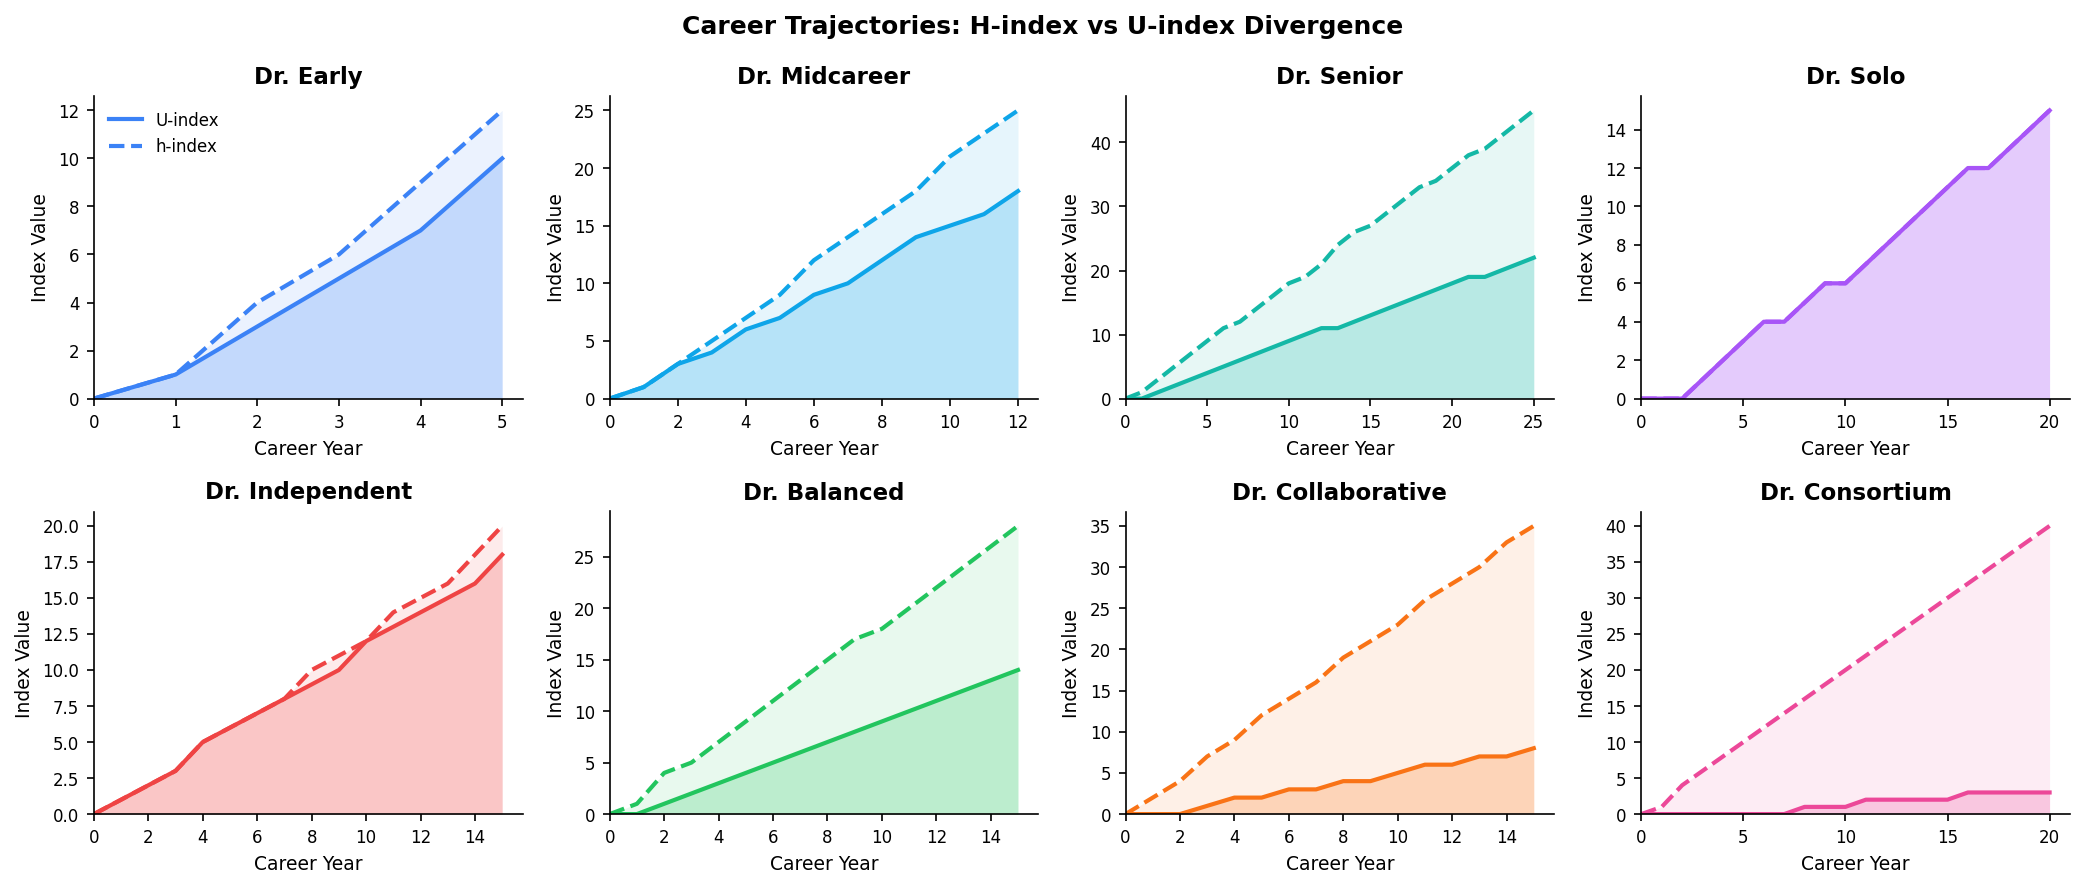

In [6]:
def create_trajectory_figure():
    """Create 2x4 grid showing career trajectories for all researchers."""

    selected = [
        "Dr. Early", "Dr. Midcareer", "Dr. Senior", "Dr. Solo",
        "Dr. Independent", "Dr. Balanced", "Dr. Collaborative", "Dr. Consortium"
    ]

    colors = {
        "Dr. Solo": "#a855f7",
        "Dr. Independent": "#ef4444",
        "Dr. Early": "#3b82f6",
        "Dr. Midcareer": "#0ea5e9",
        "Dr. Balanced": "#22c55e",
        "Dr. Senior": "#14b8a6",
        "Dr. Collaborative": "#f97316",
        "Dr. Consortium": "#ec4899",
    }

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), dpi=150)
    axes = axes.flatten()

    for i, name in enumerate(selected):
        ax = axes[i]
        researcher = next(r for r in RESEARCHERS if r["name"] == name)
        color = colors[name]
        trajectory = generate_trajectory(researcher)

        years = [t[0] for t in trajectory]
        h_vals = [t[1] for t in trajectory]
        u_vals = [t[2] for t in trajectory]

        # Fill under U-index (lower bound)
        ax.fill_between(years, 0, u_vals, alpha=0.3, color=color, linewidth=0)

        # Fill between h and U (collaboration gap)
        ax.fill_between(years, u_vals, h_vals, alpha=0.1, color=color, linewidth=0)

        # U-index line (solid)
        ax.plot(years, u_vals, color=color, linewidth=2, label="U-index")

        # h-index line (dashed)
        ax.plot(years, h_vals, color=color, linewidth=2, linestyle="--", label="h-index")

        ax.set_title(name, fontsize=11, fontweight="bold")
        ax.set_xlabel("Career Year", fontsize=9)
        ax.set_ylabel("Index Value", fontsize=9)
        ax.tick_params(labelsize=8)
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Add legend only to first subplot
        if i == 0:
            ax.legend(fontsize=8, loc="upper left", frameon=False)

    fig.suptitle(
        "Career Trajectories: H-index vs U-index Divergence",
        fontsize=12,
        fontweight="bold",
        y=0.98,
    )

    plt.tight_layout()
    return fig

create_trajectory_figure()
plt.show()

## Key Insights

| Researcher | h-index | U-index | U/h | Interpretation |
|------------|---------|---------|-----|----------------|
| Dr. Solo | 15 | 15 | 100% | All impact from leadership |
| Dr. Independent | 20 | 18 | 90% | Mostly leadership |
| Dr. Collaborative | 35 | 8 | 23% | Mostly collaboration |
| Dr. Consortium | 40 | 3 | 7.5% | Almost entirely collaboration |

The U-index serves as a **conservative lower bound** on leadership impact. Two researchers with identical h-indices can have vastly different U-indices, revealing whether their impact comes from leading research or participating in collaborations.